In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd
from ML_Analysis_OptimalStimuli import LoadSelectiveData
from ML_util import *
from GazeStimuliImage import re_generate_stimuli as regesti
from preattentive_object import PreattentiveObject as preobj

device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)
learning_rate = 0.001
training_epochs = 70
batch_size = 32
# print(device)
# print(torch.version.cuda)

In [3]:

class IdentiGazeDataset(Dataset):
    def __init__(self, path) -> None:
        super().__init__()
        self.preobj = preobj(1920,1080,'black')
        self.loadSelectiveData = LoadSelectiveData(path)
        # self.loadSelectiveData.set_domain_except('cnt_x','cnt_y','Task Encoding', 'Similarity Encoding')
        self.x = self.loadSelectiveData.take_x()
        self.y = self.loadSelectiveData.take_y()
        self.image = self.loadSelectiveData.get_data().apply(lambda x: resize_img(regesti(self.preobj, self.loadSelectiveData.take_meta(x.name))), axis=1)
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, index):
        image = self.image.iloc[index]
        y = self.y.iloc[index]
        x = self.x.iloc[index,:].to_numpy()
        return {'x':x, 'image':image, 'y':y}

path = 'data/blue_medium_data_task2.csv'
myIdentiGaze = IdentiGazeDataset(path)

In [ ]:
myIdentiGaze.__getitem__(3)['x'].shape

(197,)

In [ ]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.dropout = nn.Dropout(0.2)
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1).to(device),
            nn.MaxPool2d(kernel_size=2, stride=2).to(device),
            nn.ReLU().to(device),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=1).to(device),
            nn.MaxPool2d(kernel_size=2, stride=2).to(device),
            nn.ReLU().to(device),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1).to(device),
            nn.MaxPool2d(kernel_size=2, stride=2).to(device),
            nn.ReLU().to(device),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=2, padding=1).to(device),
            nn.MaxPool2d(kernel_size=2, stride=2).to(device),
            nn.ReLU().to(device)
                                    )
        self.layer2 = nn.Sequential(
            nn.Linear(197,100).to(device),
            nn.ReLU().to(device),
            nn.Linear(100,100).to(device),
            nn.ReLU().to(device),
            nn.Linear(100,100).to(device),
            nn.ReLU().to(device),
            nn.Linear(100,100).to(device),
            nn.ReLU().to(device),
            nn.Linear(100,100).to(device),
            nn.ReLU().to(device)
                                    )
        
        self.fusionLayer = nn.Sequential(
            nn.Linear(388, 388).to(device),
            nn.ReLU().to(device),
            nn.Linear(388, 240).to(device),
            nn.ReLU().to(device),
            nn.Linear(240, 100).to(device),
            nn.ReLU().to(device),
            nn.Linear(100, 50).to(device),
            nn.ReLU().to(device),
            nn.Linear(50, 20).to(device),
            nn.ReLU().to(device),
            nn.Linear(20, 13).to(device),
        )

    def forward(self, image, x):
        image = image.view(-1, 3, 200, 200)
        image = self.layer1(image)
        image = torch.flatten(image, 1)
        x = self.layer2(x)
        x = self.dropout(x)
        x_fusion = torch.cat((image, x),dim=1)
        out = self.fusionLayer(x_fusion)
        return out


In [ ]:
IdentiGazeNet = Model()
# output = IdentiGazeNet(torch.randn(100,3,200,200).to(device), torch.randn(100,145).to(device))
# print(len(myIdentiGaze))

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(IdentiGazeNet.parameters(), lr=learning_rate, weight_decay=1e-5)

In [ ]:
train_size = int(len(myIdentiGaze)*0.8)
test_size = len(myIdentiGaze) - train_size
train_dataset, test_dataset = random_split(myIdentiGaze, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
for epoch in range(training_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader):
        x = data['x'].to(device).type(dtype=torch.float32)
        image = data['image'].to(device).type(dtype=torch.float32)
        y = data['y'].to(device)
        optimizer.zero_grad()
        outputs = IdentiGazeNet(image, x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 30 == 29:
            print(f"[{epoch+1}, {i+1:5d}] loss: {running_loss / 2000:.3f}")
            running_loss = 0.0
    
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in test_loader:
            x_test = data['x'].to(device).type(dtype=torch.float32)
            image_test = data['image'].to(device).type(dtype=torch.float32)
            y_test = data['y'].to(device)
            # calculate outputs by running images through the network
            outputs = IdentiGazeNet(image_test, x_test)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += y_test.size(0)
            correct += (predicted == y_test).sum().item()
    print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')
    torch.save(IdentiGazeNet.state_dict(), f'ml-results/DL/IdentiGazenet_task2_{epoch}_{100 * correct // total}.pth')

[1,    30] loss: 0.039
[1,    60] loss: 0.038
[1,    90] loss: 0.038
[1,   120] loss: 0.038
[1,   150] loss: 0.038
[1,   180] loss: 0.038
[1,   210] loss: 0.037
[1,   240] loss: 0.036
[1,   270] loss: 0.036
[1,   300] loss: 0.037
Accuracy of the network on the 10000 test images: 15 %
[2,    30] loss: 0.035
[2,    60] loss: 0.035
[2,    90] loss: 0.036
[2,   120] loss: 0.035
[2,   150] loss: 0.035
[2,   180] loss: 0.035
[2,   210] loss: 0.035
[2,   240] loss: 0.034
[2,   270] loss: 0.035
[2,   300] loss: 0.035
Accuracy of the network on the 10000 test images: 14 %
[3,    30] loss: 0.034
[3,    60] loss: 0.035
[3,    90] loss: 0.034
[3,   120] loss: 0.034
[3,   150] loss: 0.035
[3,   180] loss: 0.035
[3,   210] loss: 0.035


: 

: 

In [9]:
torch.save(IdentiGazeNet.state_dict(), 'ml-results/DL/IdentiGazenet3.pth')

In [9]:
load_bestModel = Model()
load_bestModel.load_state_dict(torch.load('ml-results/DL/IdentiGazenet39_31.pth'))
load_bestModel.to(device)
load_bestModel.eval()


correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_loader:
        x_test = data['x'].to(device).type(dtype=torch.float32)
        image_test = data['image'].to(device).type(dtype=torch.float32)
        y_test = data['y'].to(device)
        # calculate outputs by running images through the network
        outputs = IdentiGazeNet(image_test, x_test)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += y_test.size(0)
        correct += (predicted == y_test).sum().item()
print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 8 %


In [42]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in range(13)}
total_pred = {classname: 0 for classname in range(13)}

# again no gradients needed
with torch.no_grad():
    for data in test_loader:
        x_test = data['x'].to(device).type(dtype=torch.float32)
        image_test = data['image'].to(device).type(dtype=torch.float32)
        y_test = data['y'].to(device)
        # calculate outputs by running images through the network
        outputs = IdentiGazeNet(image_test, x_test)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(y_test, predictions):
            if label == prediction:
                correct_pred[int(label)] += 1
            total_pred[int(label)] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname} is {accuracy:.1f} %')

Accuracy for class: 0 is 12.7 %
Accuracy for class: 1 is 24.3 %
Accuracy for class: 2 is 40.0 %
Accuracy for class: 3 is 16.5 %
Accuracy for class: 4 is 36.5 %
Accuracy for class: 5 is 18.5 %
Accuracy for class: 6 is 16.3 %
Accuracy for class: 7 is 54.2 %
Accuracy for class: 8 is 45.8 %
Accuracy for class: 9 is 31.8 %
Accuracy for class: 10 is 30.6 %
Accuracy for class: 11 is 27.0 %
Accuracy for class: 12 is 60.6 %


In [43]:
dataiter = iter(test_loader)
data_test = next(dataiter)
x_test = data_test['x'].to(device).type(dtype=torch.float32)
image_test = data_test['image'].to(device).type(dtype=torch.float32)
y_test = data_test['y'].to(device)
print('GroundTruth: ', ' '.join(f'{y_test[j]}' for j in range(20)))
outputs = IdentiGazeNet(image_test, x_test)
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join(f'{predicted[j]}' for j in range (20)))

GroundTruth:  12 12 3 4 4 9 9 10 2 9 12 0 5 6 5 10 12 3 3 7
Predicted:  7 12 12 4 4 5 9 11 1 4 10 5 1 2 6 10 12 10 4 7


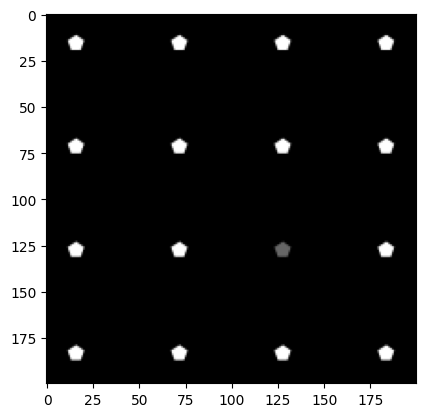

145


In [42]:
x1, image1, y1 = myIdentiGaze.__getitem__(1521)
exampleimage = np.array(image1, dtype=np.uint8)
plt.imshow(exampleimage)
plt.show()
print(len(x1))